In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [99]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv

--2020-01-16 16:23:38--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.88.2
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.88.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687088084 (655M) [text/csv]
Saving to: ‘yellow_tripdata_2019-01.csv.6’

yellow_tripdata_201 100%[===================>] 655.26M  98.3MB/s    in 6.9s    

2020-01-16 16:23:45 (94.4 MB/s) - ‘yellow_tripdata_2019-01.csv.6’ saved [687088084/687088084]



# Data PreProcessing

In [100]:
data = pd.read_csv('/content/yellow_tripdata_2019-01.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667792 entries, 0 to 7667791
Data columns (total 18 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtypes: float64(9), int64(6), object(3)
memory usage: 1.0+ GB


- Check for Missing Value

In [102]:
data.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4855978
dtype: int64

- Apart from congestion surchage, there are no missing values. 
- Drop the column becuase over 50% of it's content are missing.

In [0]:
#drop congestion surchage
data = data.drop(['congestion_surcharge'], axis=1)

In [104]:
data.shape

(7667792, 17)

- Over 7 million rows and 17 columns

In [0]:
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])


- Handling Outliers
- From the analysis from the analysis notebook. There where outliers in both the trip distance and fare amount.


In [0]:
data.drop(data[data['fare_amount'] > 5000].index, axis=0, inplace=True)
data.drop(data[data['trip_distance'] > 200].index, axis=0, inplace=True)


- Drop data where the tip amount is greater than 0 but the trip distance is 0. These are possible outliers.

In [0]:
data.drop(data[(data['tip_amount'] > 0) & (data['trip_distance'] == 0)].index, axis=0, inplace=True)

In [108]:
data.shape

(7648755, 17)

# Feature Engineering and Selection

Handling Datetime Columns

- Convert the drop off and pickup to datetime
- Extract day, date, and time and hour from the datetime columns
- Drop off datetime columns.

In [0]:
#data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.day
data['dropoff_date'] = data['tpep_dropoff_datetime'].dt.date
data['dropoff_time'] = data['tpep_dropoff_datetime'].dt.time
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

#data['pickup_day'] = data['tpep_pickup_datetime'].dt.day
data['pickup_date'] = data['tpep_pickup_datetime'].dt.date
data['pickup_time'] = data['tpep_pickup_datetime'].dt.time
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour

- Categorize hour columns into time period(Morning, Night or Evening)
- Drop the hour column.

In [0]:
bins = [0,6,12,16,20,24]
time_period = ['Early Morning','Morning','Noon','Evening','Night']
data['pickup_time_period'] = pd.cut(data['pickup_hour'], bins=bins, labels=time_period)
data['dropoff_time_period'] = pd.cut(data['dropoff_hour'], bins=bins, labels=time_period)

In [0]:
data = data.drop(data[['tpep_dropoff_datetime']], axis=1)
data = data.drop(data[['tpep_pickup_datetime']], axis=1)
data = data.drop(data[['pickup_hour']], axis=1)
data = data.drop(data[['dropoff_hour']], axis=1)

- Drop data where the pickup date is greater than the dropoff date. This means the driver was picked up today and dropped off yesterday.

In [0]:
data.drop(data[data['pickup_date']> data['dropoff_date']].index, axis=0,inplace=True)

- Check for Cardinality
  - No cardinal column in the data

In [113]:
data.nunique().sort_values()

store_and_fwd_flag           2
VendorID                     3
improvement_surcharge        4
payment_type                 4
pickup_time_period           5
dropoff_time_period          5
RatecodeID                   7
passenger_count             10
mta_tax                     10
extra                       35
dropoff_date                58
pickup_date                 58
DOLocationID               261
PULocationID               263
tolls_amount               880
tip_amount                3223
trip_distance             4385
fare_amount               6102
total_amount             11885
dropoff_time             86400
pickup_time              86400
dtype: int64

- Label Encode categorical Feature

In [0]:
#convert the time period columns to object
data['pickup_time_period'] = data['pickup_time_period'].astype('str')
data['dropoff_time_period'] = data['dropoff_time_period'].astype('str')

In [0]:
col = ['store_and_fwd_flag', 'pickup_time_period', 'dropoff_time_period']

encoder = LabelEncoder()
for column in col:
  data[column] = encoder.fit_transform(data[column])


In [116]:
data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_date,dropoff_time,pickup_date,pickup_time,pickup_time_period,dropoff_time_period
0,1,1,1.5,1,0,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,2019-01-01,00:53:20,2019-01-01,00:46:40,5,5
1,1,1,2.6,1,0,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,2019-01-01,01:18:59,2019-01-01,00:59:47,5,0
2,2,3,0.0,1,0,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,2018-12-21,13:52:40,2018-12-21,13:48:30,4,4
3,2,5,0.0,1,0,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,2018-11-28,15:55:45,2018-11-28,15:52:25,4,4
4,2,5,0.0,2,0,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,2018-11-28,15:58:33,2018-11-28,15:56:57,4,4


- Drop the date and time column because of data leakages and overfitting.

In [0]:
column = ['dropoff_date', 'dropoff_time', 'pickup_date', 'pickup_time']
data = data.drop(columns=column, axis=1)

- Split the dataset into train, test and validation.

In [0]:
label = data['tip_amount']
data = data.drop(data[['tip_amount']], axis=1)

In [0]:
scale = StandardScaler()
scaled_data = scale.fit_transform(data)

In [0]:
dev_set_X, X_test, dev_set_y, y_test = train_test_split(scaled_data, label, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(dev_set_X, dev_set_y, test_size=0.1, random_state=42)

# Model

In [121]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
pred= reg.predict(X_val)

In [123]:
print(reg.score(X_train, y_train))

0.9983360913084012


In [124]:
print(reg.score(X_val, y_val))

0.9983899424595478


In [125]:
rmse = np.sqrt(mean_squared_error(y_val, pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.09814050847657745


#Regularization

In [126]:
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [127]:
# Compute and print the coefficients
lasso_coef = lasso.coef_
len(lasso_coef)

16

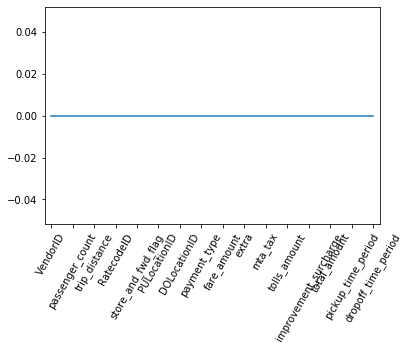

In [128]:
# Plot the coefficients
plt.plot(range(len(data.columns)), lasso_coef)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [0]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)